## Import packages

In [81]:
import pandas as pd
import numpy as np
from time import time

import requests
import bs4

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Read dataset

In [3]:
news = pd.read_csv('fake_or_real_news.csv', index_col=0) # set the first column as the index

In [4]:
news.head()

,title,text,label
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


## Clean the data

#### Remove duplicate rows

In [5]:
news[['title', 'label']].groupby('label').describe()

title                                           
      count unique                            top freq
label                                                 
FAKE   3164   3107    Michael Moore Owes Me $4.99    3
REAL   3171   3149  OnPolitics | 's politics blog    5

In [14]:
news[['text', 'label']].groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
FAKE   3164   3071                                                      36
REAL   3171   2989  Killing Obama administration rules, dismantlin...   58

In [13]:
news.loc[news['title'] == 'OnPolitics | \'s politics blog']

,title,text,label
1951,OnPolitics | 's politics blog,What you need to know about the election recou...,REAL
4337,OnPolitics | 's politics blog,Who has Trump picked for his Cabinet so far?\n...,REAL
1672,OnPolitics | 's politics blog,Who has Trump appointed to his cabinet so far?...,REAL
1762,OnPolitics | 's politics blog,Who has Trump appointed to his cabinet so far?...,REAL
2271,OnPolitics | 's politics blog,Who has Trump appointed to his cabinet so far?...,REAL


* Therefore, there are some duplicate rows in the dataset.

In [33]:
# Remove the duplicate rows
news=news.drop_duplicates(keep='first')

#### Create binary label

In [35]:
le2 = LabelEncoder()
news['binary_label']=le2.fit_transform(news['label'])

In [36]:
news = news.reset_index(drop=True)

In [37]:
news.head()

,title,text,label,binary_label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,1
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,1


## Visualization analysis

In [38]:
news['length_title'] = news['title'].apply(len)
news['length_text'] = news['text'].apply(len)
news.head()

,title,text,label,binary_label,length_title,length_text
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0,28,7518
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0,85,2646
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,1,43,2543
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0,84,2660
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,1,48,1840


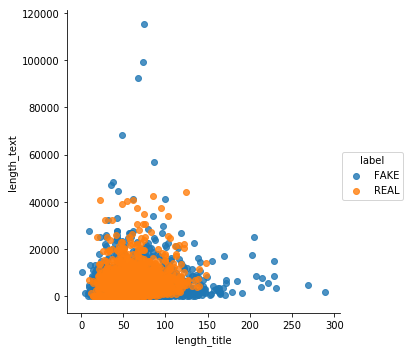

In [154]:
sns.lmplot( x="length_title", y="length_text", data=news, fit_reg=False, hue='label', legend=True)

In [283]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter
def count_top_word(dataset):
    count_word = dataset.text.apply(RegexpTokenizer(r'\w+').tokenize)
    words = []
    for i in count_word:
        words.extend(i)

    words = [i for i in words if i.lower() not in stop_word]
    
    rslt = pd.DataFrame(Counter(words).most_common(20), columns=['Word', 'Frequency']).set_index('Word')
    #print(rslt)

    # plot
    rslt.plot.bar(rot=0, figsize=(16,10), width=0.8)
    plt.xticks(rotation=45)

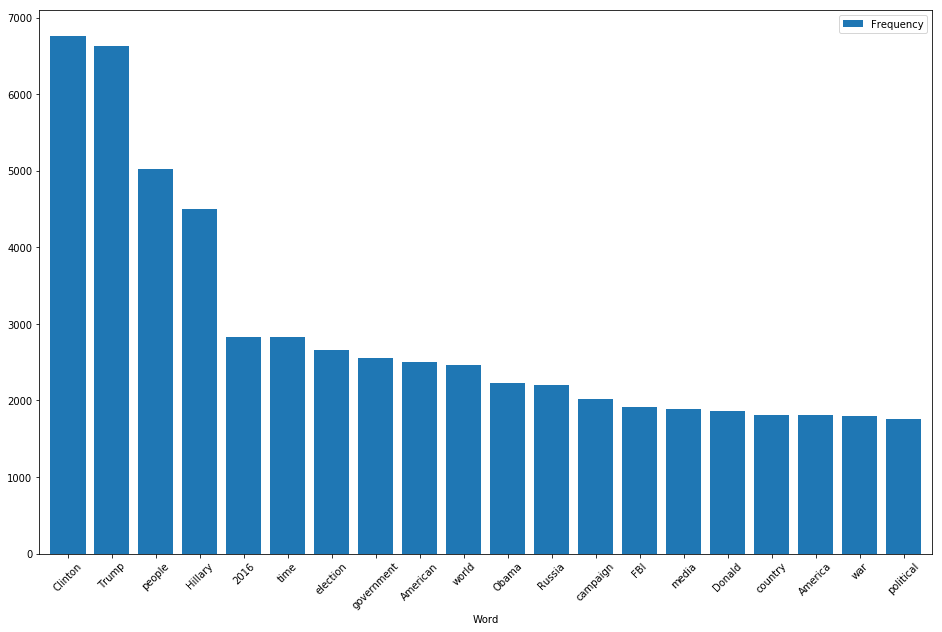

In [284]:
count_top_word(news[news['label']=='FAKE'])

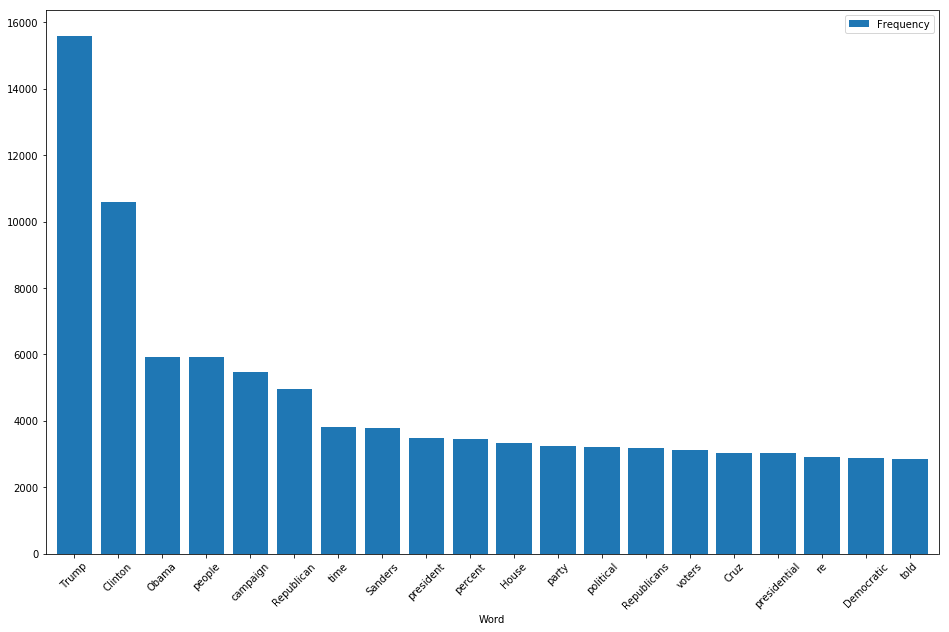

In [285]:
count_top_word(news[news['label']=='REAL'])

## Stop words list

* I plan to try three types of stop words. One is the scikit-learn english stop words, the other is the the stopwords file from the Onix. The third one is created by union the previous two stop word list.

#### Download the stopwords file from the website

In [131]:
res = requests.get('http://www.lextek.com/manuals/onix/stopwords1.html')
soup = bs4.BeautifulSoup(res.text,"lxml")
stop_word=[tag.text for tag in soup.select('pre')]
stop_word=[l.split('\n\n') for l in stop_word]
stop_word=stop_word[0][6:]

#### scikit-learn english stop words

In [134]:
from sklearn.feature_extraction import stop_words

stop_words_english = stop_words.ENGLISH_STOP_WORDS
stop_words_english = list(stop_words_english)

#### Union the two stop words

In [135]:
stop_word == stop_words_english

False

In [137]:
stop_words_union = list(set(stop_words_english).union(stop_word))

## Create a function
* Creating a function which could combine the text reprocessing method and model building method  a pipeline and fine-tune the hyperparameters by grid search:

In [138]:
def pipline_grid(parameters, pip, train_x, train_y):
    
    kfold = KFold(n_splits=3, random_state=10)
    gs = GridSearchCV(pip, parameters, cv=kfold, scoring= 'accuracy')
    
    print("Performing grid search...")
    print("Pipeline:", [name for name, _ in pip.steps])
    t0 = time()
    gs.fit(train_x, train_y)
    t1 = time() 
    print("Done in %0.3fs" % (t1 - t0))
    
    print("Best score: %0.3f" % gs.best_score_)
    print("Best parameters:")
    best_parameters = gs.best_estimator_.get_params()
    for i in list(parameters_title.keys()):
        print(str(i)+' :')
        if str(i) == 'vect__stop_words':
            if best_parameters.get(i)==stop_word:
                print('stop_word')
            elif best_parameters.get(i)==stop_words_english:
                print('stop_words_english')
            elif best_parameters.get(i)==stop_words_union:
                print('stop_words_union')
        else:
            print(best_parameters.get(i))
    return t1 - t0

* Validate the model

In [91]:
def validation (test_x, test_y, model):
    # Validate
    pred = model.predict(test_x)
    score = accuracy_score(test_y, pred)
    print ("accuracy:   %0.4f" % score)
    print(classification_report(test_y, pred, target_names=['FAKE', 'REAL']))
    cf = confusion_matrix(test_y, pred)
    sns.heatmap(cf , annot=True, fmt="d", cmap="YlGnBu")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return score

## Try title as input values

#### split the data set

In [73]:
X_train_title, X_test_title, y_train, y_test = train_test_split(news['title'], 
                                                    news.binary_label , random_state=10)

### Frequency Vectors (CountVectorizer)

* Grid search

In [139]:
pipeline_count_grid = Pipeline([
    ('vect', CountVectorizer()),
    ('nb', MultinomialNB()),
])


parameters_title = {
    'vect__stop_words': (stop_word, stop_words_english, stop_words_union),
    'vect__ngram_range': ((1, 1), (1, 2), (2, 2), (3, 3)),  
    'vect__lowercase': (True, False),
    'vect__min_df': (1, 2, 3),
    'nb__alpha': np.arange(0.1,1.1,0.1),
}

In [140]:
best_parameter_title_tfidf = pipline_grid(parameters_title, pipeline_count_grid, X_train_title, y_train)

Performing grid search...
Pipeline: ['vect', 'nb']
Done in 339.894s
Best score: 0.840
Best parameters:
vect__stop_words :
stop_words_union
vect__ngram_range :
(1, 2)
vect__lowercase :
False
vect__min_df :
1
nb__alpha :
0.8


* Create pipline based on the best suitable parameters get from grid search

In [79]:
vect_title_count = CountVectorizer(stop_words=stop_words_union, 
                                   lowercase = False, min_df = 1, ngram_range = (1, 2))

nb_title_count = MultinomialNB(alpha = 0.8)

pipe_count_title = Pipeline(steps=[('vect_title_count', vect_title_count),
                                   ('nb_title_count', nb_title_count)])

pipe_count_title.fit(X_train_title, y_train)

Pipeline(memory=None,
     steps=[('vect_title_count', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_word..., vocabulary=None)), ('nb_title_count', MultinomialNB(alpha=0.8, class_prior=None, fit_prior=True))])

* Validate the model

accuracy:   0.8611
             precision    recall  f1-score   support

       FAKE       0.86      0.86      0.86       780
       REAL       0.86      0.87      0.86       797

avg / total       0.86      0.86      0.86      1577



0.8611287254280279

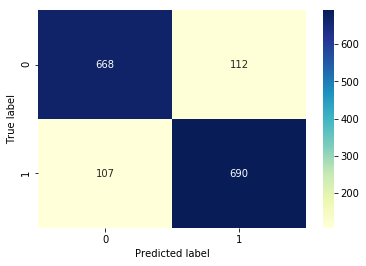

In [102]:
validation(X_test_title, y_test, pipe_count_title)

### Term Frequency–Inverse Document Frequency

* Grid search

In [98]:
pipeline_tfidf_grid = Pipeline([
    ('vect', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])


parameters_title = {
    'vect__stop_words': (stop_word, stop_words_english, stop_words_union),
    'vect__ngram_range': ((1, 1), (1, 2), (2, 2), (3, 3)),  
    'vect__lowercase': (True, False),
    'vect__min_df': (1, 2, 3),
    'nb__alpha': np.arange(0.1,1.1,0.1),
}

kfold = KFold(n_splits=3, random_state=10)

gs_title_tfidf = GridSearchCV(pipeline_tfidf_grid, parameters_title, cv=kfold, scoring= 'accuracy')


In [99]:
best_parameter_title_count = pipline_grid(parameters_title, pipeline_tfidf_grid, X_train_title, y_train)

Performing grid search...
Pipeline: ['vect', 'nb']
Done in 342.676s
Best score: 0.840
Best parameters:
vect__stop_words :
stop_word
vect__ngram_range :
(1, 2)
vect__lowercase :
False
vect__min_df :
1
nb__alpha :
0.5


* Create pipline based on the best suitable parameters get from grid search

In [100]:
vect_title_tfidf = TfidfVectorizer(stop_words = stop_word,lowercase = False, min_df = 1, ngram_range = (1, 2))
nb_title_tfidf = MultinomialNB(alpha = 0.5)

pipe_tfidf_title = Pipeline(steps=[('vect_title_tfidf', vect_title_tfidf),
                                   ('nb_title_tfidf', nb_title_tfidf)])

pipe_tfidf_title.fit(X_train_title, y_train)

Pipeline(memory=None,
     steps=[('vect_title_tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth...  vocabulary=None)), ('nb_title_tfidf', MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True))])

* Validation

accuracy:   0.8605
             precision    recall  f1-score   support

       FAKE       0.87      0.85      0.86       780
       REAL       0.85      0.87      0.86       797

avg / total       0.86      0.86      0.86      1577



0.8604946100190235

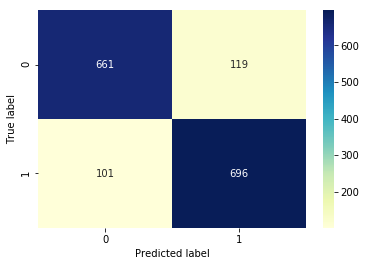

In [101]:
validation(X_test_title, y_test, pipe_tfidf_title)

## Try text as input values

In [106]:
X_train_text, X_test_text, y_train, y_test = train_test_split(news['text'], 
                                                    news.binary_label , random_state=10)

### Frequency Vectors (CountVectorizer)

* Grid search

In [121]:
pipeline_count_grid = Pipeline([
    ('vect', CountVectorizer()),
    ('nb', MultinomialNB()),
])


parameters_text = {
    'vect__ngram_range': ((1, 1), (2, 2), (3, 3)),  
    'vect__min_df': (1, 2, 3),
    'vect__lowercase': (True, False),
    'nb__alpha': [0.1, 0.3, 0.5, 0.7, 0.9, 1],
}


In [122]:
best_parameter_text_count = pipline_grid(parameters_text, pipeline_count_grid, X_train_text, y_train)

Performing grid search...
Pipeline: ['vect', 'nb']
Done in 3810.503s
Best score: 0.912
Best parameters:
vect__stop_words :
stop_words_union
vect__ngram_range :
(2, 2)
vect__lowercase :
False
vect__min_df :
3
nb__alpha :
0.1


* Create pipline based on the best suitable parameters get from grid search

In [141]:
vect_text_count = CountVectorizer(min_df = 3, ngram_range = (2, 2), lowercase = False)

nb_text_count = MultinomialNB(alpha = 0.1)

pipe_count_text = Pipeline(steps=[('vect_text_count', vect_text_count),
                                   ('nb_text_count', nb_text_count)])

pipe_count_text.fit(X_train_text, y_train)

Pipeline(memory=None,
     steps=[('vect_text_count', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(2, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('nb_text_count', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))])

* Validation

accuracy:   0.9176
             precision    recall  f1-score   support

       FAKE       0.95      0.88      0.91       780
       REAL       0.89      0.96      0.92       797

avg / total       0.92      0.92      0.92      1577



0.9175649968294229

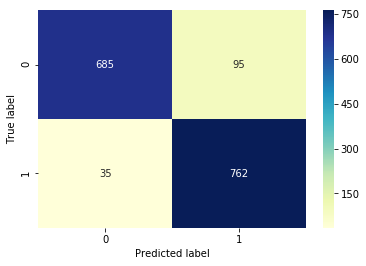

In [142]:
validation(X_test_text, y_test, pipe_count_text)

### Term Frequency–Inverse Document Frequency

* Grid search

In [294]:
pipeline_tfidf_grid = Pipeline([
    ('vect', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])


parameters_text = {
    'vect__ngram_range': ((1, 1), (1, 2), (1, 3)),  
    'vect__min_df': (1, 2, 3),
    'vect__lowercase': (True, False),
    'nb__alpha': [0.1, 0.3, 0.5, 0.7, 0.9, 1],
}



In [295]:
best_parameter_title_count = pipline_grid(parameters_text, pipeline_tfidf_grid, X_train_text, y_train)

Performing grid search...
Pipeline: ['vect', 'nb']
Done in 6446.378s
Best score: 0.920
Best parameters:
vect__stop_words :
vect__ngram_range :
(1, 3)
vect__lowercase :
False
vect__min_df :
3
nb__alpha :
0.1


* Create pipline based on the best suitable parameters get from grid search

In [151]:
vect_text_tfidf = TfidfVectorizer(lowercase = False, min_df = 3, ngram_range = (1, 3))
nb_text_tfidf = MultinomialNB(alpha = 0.1)

pipe_tfidf_text = Pipeline(steps=[('vect_text_tfidf', vect_text_tfidf),
                                   ('nb_text_tfidf', nb_text_tfidf)])

pipe_tfidf_text.fit(X_train_text, y_train)

Pipeline(memory=None,
     steps=[('vect_text_tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_...   vocabulary=None)), ('nb_text_tfidf', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))])

* Validation

accuracy:   0.9233
             precision    recall  f1-score   support

       FAKE       0.96      0.88      0.92       780
       REAL       0.89      0.96      0.93       797

avg / total       0.93      0.92      0.92      1577



0.9232720355104629

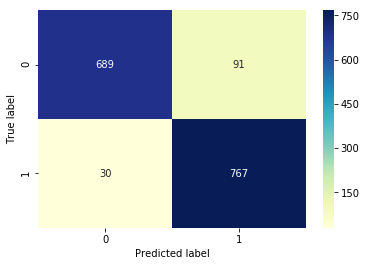

In [152]:
validation(X_test_text, y_test, pipe_tfidf_text)

#### Conclusion 1:
* The classifiers built with news text performance better than built with news title;
* Classifier built with Tfidf Vectorizer and Mulitnomial Naive Bayes has higher accuracy compared with that with Count Vectorizer. The best hyperparameters for the best performing model are:


### Based on the outcome I have got now, I plan to use the Tfidf Vectorizer with the best parameters as my preprocessing method and try other normally used sentiment analysis algorithms such as: Logistic Regression and Linear Support Vector Machine.

## Preprocessing features

In [299]:
tfidf = TfidfVectorizer(lowercase = False, min_df = 3, ngram_range = (1, 3)) 
tfidf_train_x = tfidf.fit_transform(X_train_text) 
tfidf_test_x = tfidf.transform(X_test_text)

## Logistic regression

In [305]:
from sklearn.linear_model import LogisticRegression

* Grid Search

In [302]:
logit_param={"C":[0.001,0.01,0.1,1,10,100]}

kfold=KFold(n_splits=3, random_state=10)

logit_grid = GridSearchCV(LogisticRegression() , logit_param, cv=kfold, scoring= 'accuracy')

#Fitting
logit_grid.fit(tfidf_train_x, y_train)

#Printing reports
print("Best Parameters: {}".format(logit_grid.best_params_))
print("Best cross-validation Accuracy: {:.4f}".format(logit_grid.best_score_))
print("Best estimator:\n{}".format(logit_grid.best_estimator_))

Best Parameters: {'C': 100}
Best cross-validation Accuracy: 0.9317
Best estimator:
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


* Build logistic model with best parameter

In [303]:
logisticRegression = LogisticRegression(C = 100).fit(tfidf_train_x, y_train) 

* Validation

accuracy:   0.9461
             precision    recall  f1-score   support

       FAKE       0.94      0.96      0.95       780
       REAL       0.96      0.94      0.95       797

avg / total       0.95      0.95      0.95      1577



0.9461001902346227

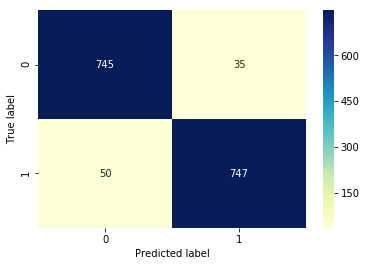

In [304]:
validation(tfidf_test_x, y_test, logisticRegression)

## Linear Support Vector Machine

* I have tried nonlinear SVC ,but the classifier blindly assigns all the outcomes to 0 (FAKE). 
* Linear SVC works good on this dataset.

In [317]:
from sklearn.svm import LinearSVC

In [320]:
linearSVCparam={"C":[0.001, 0.01, 0.1, 1, 10, 100, 1000],
               "loss": ['hinge', 'squared_hinge']}

kfold = KFold(n_splits=3, random_state=10)

grid_linearSVC=GridSearchCV(LinearSVC(), linearSVCparam, cv=kfold, scoring= 'accuracy')

#Fitting
grid_linearSVC.fit(tfidf_train_x, y_train)

#Print reports
print("Best K: {}".format(grid_linearSVC.best_params_))
print("Best cross-validation Accuracy: {:.4f}".format(grid_linearSVC.best_score_))
print("Best estimator:\n{}".format(grid_linearSVC.best_estimator_))

Best K: {'C': 1, 'loss': 'hinge'}
Best cross-validation Accuracy: 0.9342
Best estimator:
LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)


In [321]:
linearSVC = LinearSVC(C = 1, loss = 'hinge').fit(tfidf_train_x, y_train) 

accuracy:   0.9505
             precision    recall  f1-score   support

       FAKE       0.94      0.96      0.95       780
       REAL       0.96      0.94      0.95       797

avg / total       0.95      0.95      0.95      1577



0.9505389980976537

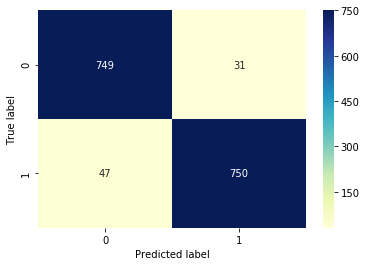

In [322]:
validation(tfidf_test_x, y_test, linearSVC)

#### Finally, the linear SVC get the highest accuracy score on test dataset which is 95.05%